<a href="https://colab.research.google.com/github/aichajeral1/aichajeral1/blob/main/GWP_3_MScFE622_Stochastic_Modeling_Group_3588.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 622 Stochastic Modeling Group Work Project # 3
Authors:

Jatin Patni(jatinpatni@gmail.com),

Olabode Samuel James (jamesolabodes@gmail.com) and

Eugene Aicha(aichajeral@gmail.com)

Group No:  3588

## Summary -

As required for this report, we have describe the portfolio selection problem as a multi-armed bandit problem, a sequential decision-making problem under reinforcement learning problem. While trying to model the problem of portfolio selection, we studied the steps from the Huo (2017) paper.

The problem, as outlined in this report involved making sequential decisions, learning from actions, and optimizing the decision-making process based on rewards. From a finance and investment perspective, the portfolio selection problem being framed as a multi-armed bandit problem, implied setting a set of investment options (arms) and then decide how to allocate the resources (pulls) to maximize the returns over time.

While implementing this problem, we have used 30 Stocks(split into 15 finance and 15 non-finance stocks) to represent a 30-arm bandit problem and implementation the solution to compare with an average reward with even weight allocation for all stocks in the portfolio of interest.

The task was then concluded by comparing Average frequency of optimal action, Average annualized return from holding the equally-weighted portfolio and the Average annualized return from holding the Bandit portfolio under various performance parameters under UCB(Upper-Confidence Bound) and epsilon-greedy Implementations of the Multi-arm Bandit problem scenario.

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import math
import random
from numpy.random import rand, seed

from datetime import datetime

import yfinance as yf
from typing import Tuple
import pandas_datareader.data as web


# importing numpy as np
# for Mathematical calculations


# importing pyplot from matplotlib as plt
# for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
%matplotlib inline

In [ ]:
import sys
sys.path.append('..')

import warnings
# Ignore all warnings (not recommended in most cases)
warnings.filterwarnings("ignore")

## Helper Classes and Functions

### Extract Equity, Index and Crypto Data

In [ ]:
# A Custom Package for effective Importation of Financial Data
class HistoricalData():
    def __init__(self):
        self.config = {
            "period": "max",
            "interval": "1d",
            "prepost": True,
            "threads": True,
            "groupby": "ticker"
        }


    def retrieve_data(self, *stock_ticker: Tuple) -> pd.DataFrame:
        formatted_tickers = " ".join([x for x in stock_ticker])
        self.data = yf.download(tickers=formatted_tickers,
                            period=self.config["period"],
                            interval=self.config["interval"],
                            prepost=self.config["prepost"],
                            threads=self.config["threads"],
                            group_by=self.config["groupby"])


    def save_data_to_csv(self, filename:str='historical_data'):
        self.data.to_csv(f'{filename}.csv')
        print(f'{filename} saved!')


In [ ]:
def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa


def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

### UCB Algorithm For Multi-arm Bandit

In [ ]:
def ucb_algorithm(data, exploration_rate, confidence_interval):
  # Set the number of assets and total time steps
  num_assets = len(combined_tickers)
  T = len(data)

  # Initialize arrays for historical returns and counts
  # historical_returns = combined_data.pct_change().mean().to_dict()
  historical_returns = np.zeros(num_assets)
  counts = np.zeros(num_assets)

  # Initialize the portfolio as an empty list
  portfolio = []

  # Loop through each time step
  for t in range(T):
      # Exploration-Exploitation Trade-off
      ucb_values = []
      for i in range(num_assets):
          assetName = combined_tickers[i]
          if counts[i] == 0:
              ucb_values.append(float('inf'))  # Handle unexplored arms
          else:
              ucb = historical_returns[i] + exploration_rate*np.sqrt(2 * math.log(t + 1) / counts[i])
              ucb_values.append(ucb)

      # Select the asset with the highest UCB
      selected_asset = np.argmax(ucb_values)
      selected_asset_name = combined_tickers[selected_asset]
      # Observe the return of the selected asset
      observed_return = data['Adj Close'][selected_asset_name][t]

      # Update historical return and count for the selected asset
      historical_returns[selected_asset] += observed_return
      counts[selected_asset] += 1

      # Add the selected asset to the portfolio
      portfolio.append(combined_tickers[selected_asset])

  # Print the final selected portfolio
  print("Selected Portfolio:", portfolio)
  return portfolio

Part 2

In [ ]:
# Bandit problem for stock selection

def ucb_algo_complete(pdata, epsilon, alpha, hold, ucb_weight):
  #NK = 5
  NK = pdata.shape[1]

  #Parameter for epsilon-greedy
  EPSILON = epsilon

  ALPHA = alpha
  NEPISODES = 1000
  HOLD = hold
  TMAX = pdata.shape[0] - HOLD
  #Parameter For UCB
  UCB_WEIGHT = ucb_weight
  seed(1234)

  reward_avg = np.zeros((TMAX))
  optimal_avg = np.zeros((TMAX))

  reward_queue = np.zeros((HOLD, 2))

  for run in range(NEPISODES):  # noQA E203
      # Initialize q function and actions record
      qvalue = np.zeros((NK))
      qvalue_up = np.zeros((NK))
      nactions = np.zeros((NK))
      for tt in range(TMAX):  # noQA E203
          aa_opt = optimal_action(qvalue_up, EPSILON)
          nactions[aa_opt] += 1
          # Compute reward as return over holding period
          #reward_queue[HOLD - 1, 0] = (YData[tt + HOLD, aa_opt] - YData[tt, aa_opt]) / YData[tt, aa_opt]
          reward_queue[HOLD - 1, 0] = (pdata[tt + HOLD, aa_opt] - pdata[tt, aa_opt]) / pdata[tt, aa_opt]
          reward_queue[HOLD - 1, 1] = aa_opt
          # Update Q function using action chosen HOLD days before
          qvalue = reward_update(int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA)

          # Upper-confidence adjustment
          qvalue_up = np.zeros((NK))
          for aa in range(NK):
            #if an action has not been visited simply give it the maximum value across actions
              if nactions[aa] == 0:  # noQA E203
                  qvalue_up[aa] = np.max(qvalue) + 1.0
              else:
                  qvalue_up[aa] = qvalue[aa] + UCB_WEIGHT * np.sqrt(np.log(tt + 1) / nactions[aa]) #Here is the adjustment for the UCB
          reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
          reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
          optimal_avg[tt] += (aa_opt == np.argmax((pdata[tt + HOLD, :] - pdata[tt, :]) / pdata[tt, :])) / NEPISODES  # noQA E203

  # Average frequency of optimal action
  avg_optimal_action = np.mean(optimal_avg)
  avg_ann_ret_ewp = (
                1
                + np.mean(
                    (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :]
                )
            )** (250 / HOLD)- 1,np.sqrt(250 / HOLD) * np.std( np.mean(
                    (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :],
                    axis=1,
                ))
  avg_ann_ret_bandit = (1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,np.sqrt(250 / HOLD) * np.std(reward_avg)

  print("Average frequency of optimal action", avg_optimal_action )
  # Average annualized return from holding the equally-weighted portfolio
  print("Average annualized return from holding the equally-weighted portfolio",avg_ann_ret_ewp )  # noQA E203
  # Average annualized return from holding the Bandit portfolio
  print("Average annualized return from holding the Bandit portfolio",avg_ann_ret_bandit)
  return avg_optimal_action, avg_ann_ret_ewp, avg_ann_ret_bandit

### Epsilon-Greedy Algorithm For Multi-arm Bandit

In [ ]:
def epsilon_greedy_algorithm(data, epsilon):
  # Set the number of assets and total time steps
  num_assets = len(combined_tickers)
  T = len(data)

  # Initialize parameters
  # epsilon = 0.3 # Exploration rate
  historical_returns = np.zeros(num_assets)
  counts = np.zeros(num_assets)

  # Initialize the portfolio as an empty list
  portfolio = []

  # Loop through each time step
  for t in range(T):
      # Exploration-Exploitation Trade-off
      if random.random() < epsilon:
          # Exploration: Choose a random asset
          selected_asset = random.randint(0, num_assets - 1)
      else:
          # Exploitation: Choose the asset with the highest historical return
          selected_asset = np.argmax(historical_returns)

      # Observe the return of the selected asset
      observed_return = data['Adj Close'][combined_tickers[selected_asset]][t]

      # Update historical return and count for the selected asset
      historical_returns[selected_asset] += observed_return
      counts[selected_asset] += 1

      # Add the selected asset to the portfolio
      portfolio.append(combined_tickers[selected_asset])

  # Print the final selected portfolio
  print("Selected Portfolio:", portfolio)
  return portfolio

Part 2

In [ ]:
# Bandit problem for stock selection

def epsilon_greedy_complete(pdata, epsilon, alpha, hold):
  #NK = 5
  NK = pdata.shape[1]

  #Parameter for epsilon-greedy
  #EPSILON = 0.1
  EPSILON = epsilon #To implement a greedy algorithm, but allow for full implementation of UCB

  ALPHA = alpha
  NEPISODES = 1000
  HOLD = hold
  TMAX = pdata.shape[0] - HOLD

  np.random.seed(1234)

  reward_avg = np.zeros((TMAX))
  optimal_avg = np.zeros((TMAX))

  reward_queue = np.zeros((HOLD, 2))

  for run in range(NEPISODES):  # noQA E203
      # Initialize q function and actions record
      qvalue = np.zeros((NK))
      qvalue_up = np.zeros((NK))
      nactions = np.zeros((NK))
      for tt in range(TMAX):  # noQA E203
          aa_opt = optimal_action(qvalue_up, EPSILON)
          nactions[aa_opt] += 1
          # Compute reward as return over holding period
          reward_queue[HOLD - 1, 0] = (
              pdata[tt + HOLD, aa_opt] - pdata[tt, aa_opt]
          ) / pdata[tt, aa_opt]
          reward_queue[HOLD - 1, 1] = aa_opt
          # Update Q function using action chosen HOLD days before
          qvalue = reward_update(
              int(reward_queue[0, 1]), reward_queue[0, 0], qvalue, ALPHA
          )
          # Upper-confidence adjustment
          qvalue_up = np.zeros((NK))
          for aa in range(NK):
              if nactions[aa] == 0:  # noQA E203
                  qvalue_up[aa] = np.max(qvalue) + 1.0
              else:
                  qvalue_up[aa] = qvalue[aa] + np.sqrt(np.log(tt + 1) / nactions[aa])
          reward_queue[0 : HOLD - 1, :] = reward_queue[1:HOLD, :]  # noQA E203
          reward_avg[tt] += reward_queue[HOLD - 1, 0] / NEPISODES
          optimal_avg[tt] += (
              aa_opt == np.argmax((pdata[tt + HOLD, :] - pdata[tt, :]) / pdata[tt, :])
          ) / NEPISODES  # noQA E203


 # Average frequency of optimal action
  avg_optimal_action = np.mean(optimal_avg)
  avg_ann_ret_ewp = (
                1
                + np.mean(
                    (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :]
                )
            )** (250 / HOLD)- 1,np.sqrt(250 / HOLD) * np.std( np.mean(
                    (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :],
                    axis=1,
                ))
  avg_ann_ret_bandit = (1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,np.sqrt(250 / HOLD) * np.std(reward_avg)

  print("Average frequency of optimal action", avg_optimal_action )
  # Average annualized return from holding the equally-weighted portfolio
  print("Average annualized return from holding the equally-weighted portfolio",avg_ann_ret_ewp )  # noQA E203
  # Average annualized return from holding the Bandit portfolio
  print("Average annualized return from holding the Bandit portfolio",avg_ann_ret_bandit)
  return avg_optimal_action, avg_ann_ret_ewp, avg_ann_ret_bandit

### Greedy Algorithm For Multi-arm Bandit Problem

### Results DataFrame

In [ ]:
# Create a dataframe to save all results
result_df = pd.DataFrame(columns = ['Bandit Algorithm', 'Parameters', 'Avg fq of optimal action', 'Avg annualized return from EWP', 'Avg annualized return from Bandit Portfolio'])

Here Avg annualized return from EWP = Average annualized return from holding the equally-weighted portfolio

## Step 1 - Huo(2017) Summary

Risk-aware multi-armed bandit problem with application to portfolio selection - [Paper Source ](https://royalsocietypublishing.org/doi/epdf/10.1098/rsos.171377)


Summary:

Huo's 2017 work, "Risk-Aware Multi-Armed Bandit Problem with Application to Portfolio Selection," addresses a significant difficulty in decision-making under uncertainty. The article proposes and implements a unique strategy to the risk-aware multi-armed bandit issue in the context of portfolio selection. The multi-armed bandit problem concerns a trade-off between exploring new possibilities (arms) and maximizing cumulative rewards over time. The goal of financial portfolio selection is to allocate resources to a collection of assets in order to generate optimal returns while successfully controlling risks.

Huo's study proposes a risk-aware form of the traditional multi-armed bandit issue, in which the arms represent several investment possibilities with varied risk levels (Huo and Fu). The suggested method incorporates risk considerations into the decision-making process, with the goal of optimizing both projected rewards and risk management at the same time. The research provides a thorough examination of the risk-aware multi-armed bandit dilemma, generating theoretical insights and creating methods to address the issue.

Furthermore, by extending the proposed approach to the domain of portfolio selection, the research proves its practical applicability. Portfolio management is arranging investments among numerous assets in order to meet financial goals (Huo and Fu). By explicitly accounting for risk considerations, the study demonstrates how the risk-aware multi-armed bandit framework can improve portfolio selection strategies.

The study's findings add to the field of decision-making and risk management by providing a fresh look at the multi-armed bandit dilemma. Risk-awareness integration into this framework has the potential to develop a variety of applications outside portfolio selection, such as resource allocation, clinical trials, and recommendation systems (Huo and Fu). Overall, Huo's work gives useful insights into tackling decision-making issues in uncertain situations, with a focus on risk considerations.


## Step 2 - PeudoCode For Model 1 in Huo Paper

### Model 1 - PseudoCode - Sequential Portfolio Selection Problem (from the Huo paper)



```
# Model 1: Sequential Portfolio Selection Problem

# Define parameters
num_assets = number of available assets
T = number of time periods
budget = total budget available for investment

# Initialize variables
portfolio = empty list to store selected assets
remaining_budget = budget
cumulative_reward = 0

# Loop through each time period
for t = 1 to T:

    # Calculate the average return and risk of each asset
    for asset in range(num_assets):
        average_return[asset] = calculate_average_return(asset, t)
        risk[asset] = calculate_risk(asset, t)
    
    # Calculate the risk-reward ratio for each asset
    for asset in range(num_assets):
        risk_reward_ratio[asset] = average_return[asset] / risk[asset]

    # Sort assets based on the risk-reward ratio in descending order
    sorted_assets = sort_assets_by_risk_reward_ratio(risk_reward_ratio)

    # Select the asset with the highest risk-reward ratio that fits the budget
    selected_asset = None
    for asset in sorted_assets:
        if remaining_budget >= cost_of(asset):
            selected_asset = asset
            break
    
    # If an asset was selected, update the portfolio and remaining budget
    if selected_asset is not None:
        portfolio.append(selected_asset)
        remaining_budget -= cost_of(selected_asset)
        cumulative_reward += average_return[selected_asset]

# Output the final selected portfolio and cumulative reward
print("Selected Portfolio:", portfolio)
print("Cumulative Reward:", cumulative_reward)

```



### Explanation of the pseudocode:

- The program sets up parameters and vectors to keep track of previous time periods and asset amounts or counts.

- The program determines the average risk reward for each asset in each time step while looping through each time period, then ranks them in descending order.

- The asset with the highest risk-to-reward ratio that fits the budget is chosen for investment, and its return is tracked.

- Based on the observed return, the algorithm updates the historical return and count for the selected asset.

- The time step is increased, and the process is repeated until the total number of time steps is reached.

- The final portfolio is comprised of the assets chosen based on the algorithm's decisions.

- This technique seeks to strike a compromise between leveraging known high-performing assets and investigating potentially better-performing assets, resulting in an adaptive portfolio selection strategy.



The pseudocode above represents an algorithm for addressing the sequential portfolio selection problem, in which there are a limited number of available assets and the goal is to select a portfolio of assets across a predetermined number of time periods to maximize cumulative rewards. Overall, this algorithm traverses a series of time periods, calculates risk-reward ratios for accessible assets, and selects assets that provide the best risk-adjusted returns while staying within the budget constraints. It's a straightforward portfolio selection strategy that seeks to maximize cumulative returns over time.










## Step 3 - Extracting Stock Data

Data for 15 financial institutions (JPM,WFC, BAC, C, GS,USB, MS, KEY, PNC, COF, AXP, PRU, SCHW, BBT, STI)

data for 15 non-financial institutions (KR, PFE, XOM, WMT,
DAL, CSCO, HCP, EQIX, DUK, NFLX, GE, APA, F, REGN, CMS)

In [ ]:
# List of tickers
tickers_fin = ['JPM', 'WFC', 'BAC', 'C', 'GS', 'USB', 'MS', 'KEY', 'PNC', 'COF', 'AXP', 'PRU', 'SCHW', 'BBT', 'STI']
tickers_non_fin = ['KR', 'PFE', 'XOM', 'WMT', 'DAL', 'CSCO', 'HCP', 'EQIX', 'DUK', 'NFLX', 'GE', 'APA', 'F', 'REGN', 'CMS']

In [ ]:
combined_tickers = tickers_fin+tickers_non_fin
print(combined_tickers, "\nTotal Tickers",len(combined_tickers))

['JPM', 'WFC', 'BAC', 'C', 'GS', 'USB', 'MS', 'KEY', 'PNC', 'COF', 'AXP', 'PRU', 'SCHW', 'BBT', 'STI', 'KR', 'PFE', 'XOM', 'WMT', 'DAL', 'CSCO', 'HCP', 'EQIX', 'DUK', 'NFLX', 'GE', 'APA', 'F', 'REGN', 'CMS'] 
Total Tickers 30


In [ ]:
# List of tickers

# Define start and end dates
start_date = '2008-09-01'
end_date = '2008-10-31'

# Download data
data = yf.download(combined_tickers, start=start_date, end=end_date)

# Select the 'Adj Close' column for each ticker
adj_close_data = data['Adj Close']

# Print the first few rows of the data
#print(adj_close_data.head())


[*********************100%%**********************]  30 of 30 completed

ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BBT', 'STI']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:['HCP']: Exception("%ticker%: Data doesn't exist for startDate = 1220241600, endDate = 1225425600")


In [ ]:
#Corrections for STI, BBT and HCP
#Replacing - STI,BBT with TFC and BK,
#Replacing - HCP with updated - PEAK
# List of tickers
tickers_fin = ['JPM', 'WFC', 'BAC', 'C', 'GS', 'USB', 'MS', 'KEY', 'PNC', 'COF', 'AXP', 'PRU', 'SCHW', 'TFC','BK']
tickers_non_fin = ['KR', 'PFE', 'XOM', 'WMT', 'DAL', 'CSCO', 'PEAK', 'EQIX', 'DUK', 'NFLX', 'GE', 'APA', 'F', 'REGN', 'CMS']
combined_tickers = tickers_fin+tickers_non_fin

In [ ]:
# Adj Close' column for each ticker
# combined_data = data[combined_tickers]
# Download data
print(len(combined_tickers))
data = yf.download(combined_tickers, start=start_date, end=end_date)

# Select the 'Adj Close']

# Print the first few rows of the data
#print(adj_close_data.head())

30
[*********************100%%**********************]  30 of 30 completed


In [ ]:
combined_data = data['Adj Close']
combined_data.head()

,APA,AXP,BAC,BK,C,CMS,COF,CSCO,DAL,DUK,...,PFE,PNC,PRU,REGN,SCHW,TFC,USB,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-02,85.022720,31.904465,25.744051,24.882658,150.861893,8.226348,34.988823,16.482166,8.128149,26.487049,...,10.190771,49.770012,45.281342,20.580000,19.997494,18.398190,21.491514,21.058512,42.738354,44.898075
2008-09-03,85.934174,32.124325,26.524664,25.418463,154.809067,8.129642,35.565228,16.176809,8.074967,26.150990,...,10.206718,50.230839,46.485893,21.799999,20.022295,18.607128,21.876596,20.923573,42.838669,45.304562
2008-09-04,87.972969,30.428205,24.625448,24.768351,144.467407,8.141726,33.750351,15.462012,7.942011,26.410660,...,9.924968,49.302402,45.000664,20.379999,19.484730,17.926596,21.013477,20.019423,42.831501,44.212902
2008-09-05,89.092323,30.938616,25.937187,25.961412,150.546112,8.063151,34.825245,15.448127,7.809051,26.441214,...,9.839916,50.346077,46.041489,19.070000,19.923058,18.995146,21.737169,21.051767,43.519314,43.910938
2008-09-08,87.765091,31.818087,27.949076,28.418949,160.414093,8.310967,37.956486,16.218451,7.614047,27.296625,...,10.174822,52.033508,49.655102,18.900000,20.857595,20.457687,22.533886,22.644144,44.422081,44.578712


In [ ]:
tickers = combined_data.columns

In [ ]:
tickers

Index(['APA', 'AXP', 'BAC', 'BK', 'C', 'CMS', 'COF', 'CSCO', 'DAL', 'DUK',
       'EQIX', 'F', 'GE', 'GS', 'JPM', 'KEY', 'KR', 'MS', 'NFLX', 'PEAK',
       'PFE', 'PNC', 'PRU', 'REGN', 'SCHW', 'TFC', 'USB', 'WFC', 'WMT', 'XOM'],
      dtype='object')

In [ ]:
len(tickers)

30

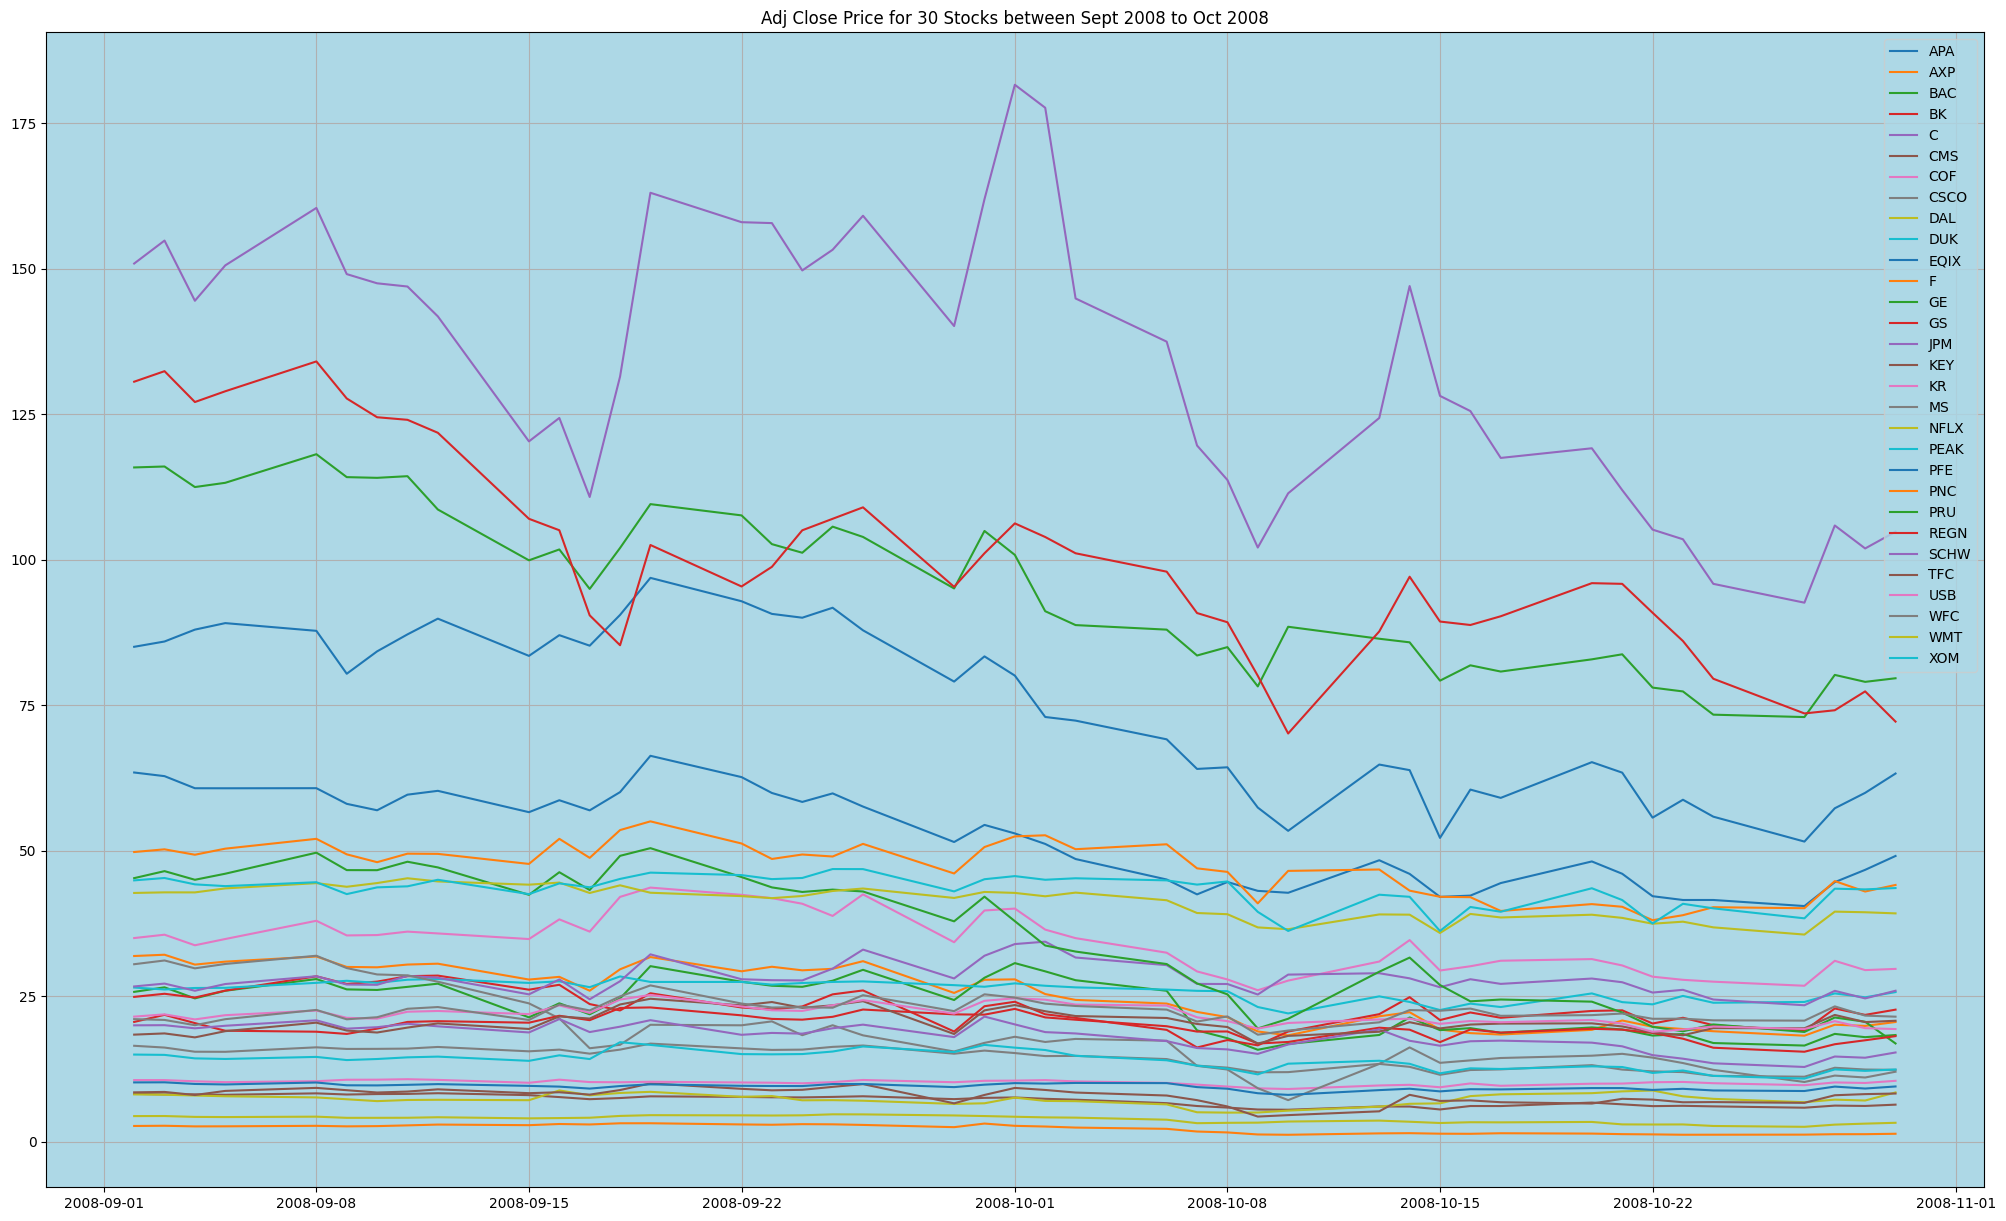

In [ ]:
### Visualising the Equity Data
plt.figure(figsize=(25,15))
plt.rcParams['axes.facecolor'] = 'lightblue'
#data = filtered_df['^GSPC', 'Adj Close']
plt.plot(combined_data.index, combined_data)
plt.title('Adj Close Price for 30 Stocks between Sept 2008 to Oct 2008')
plt.grid()
plt.legend(combined_data.columns)
plt.show()

### Cumulative Returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

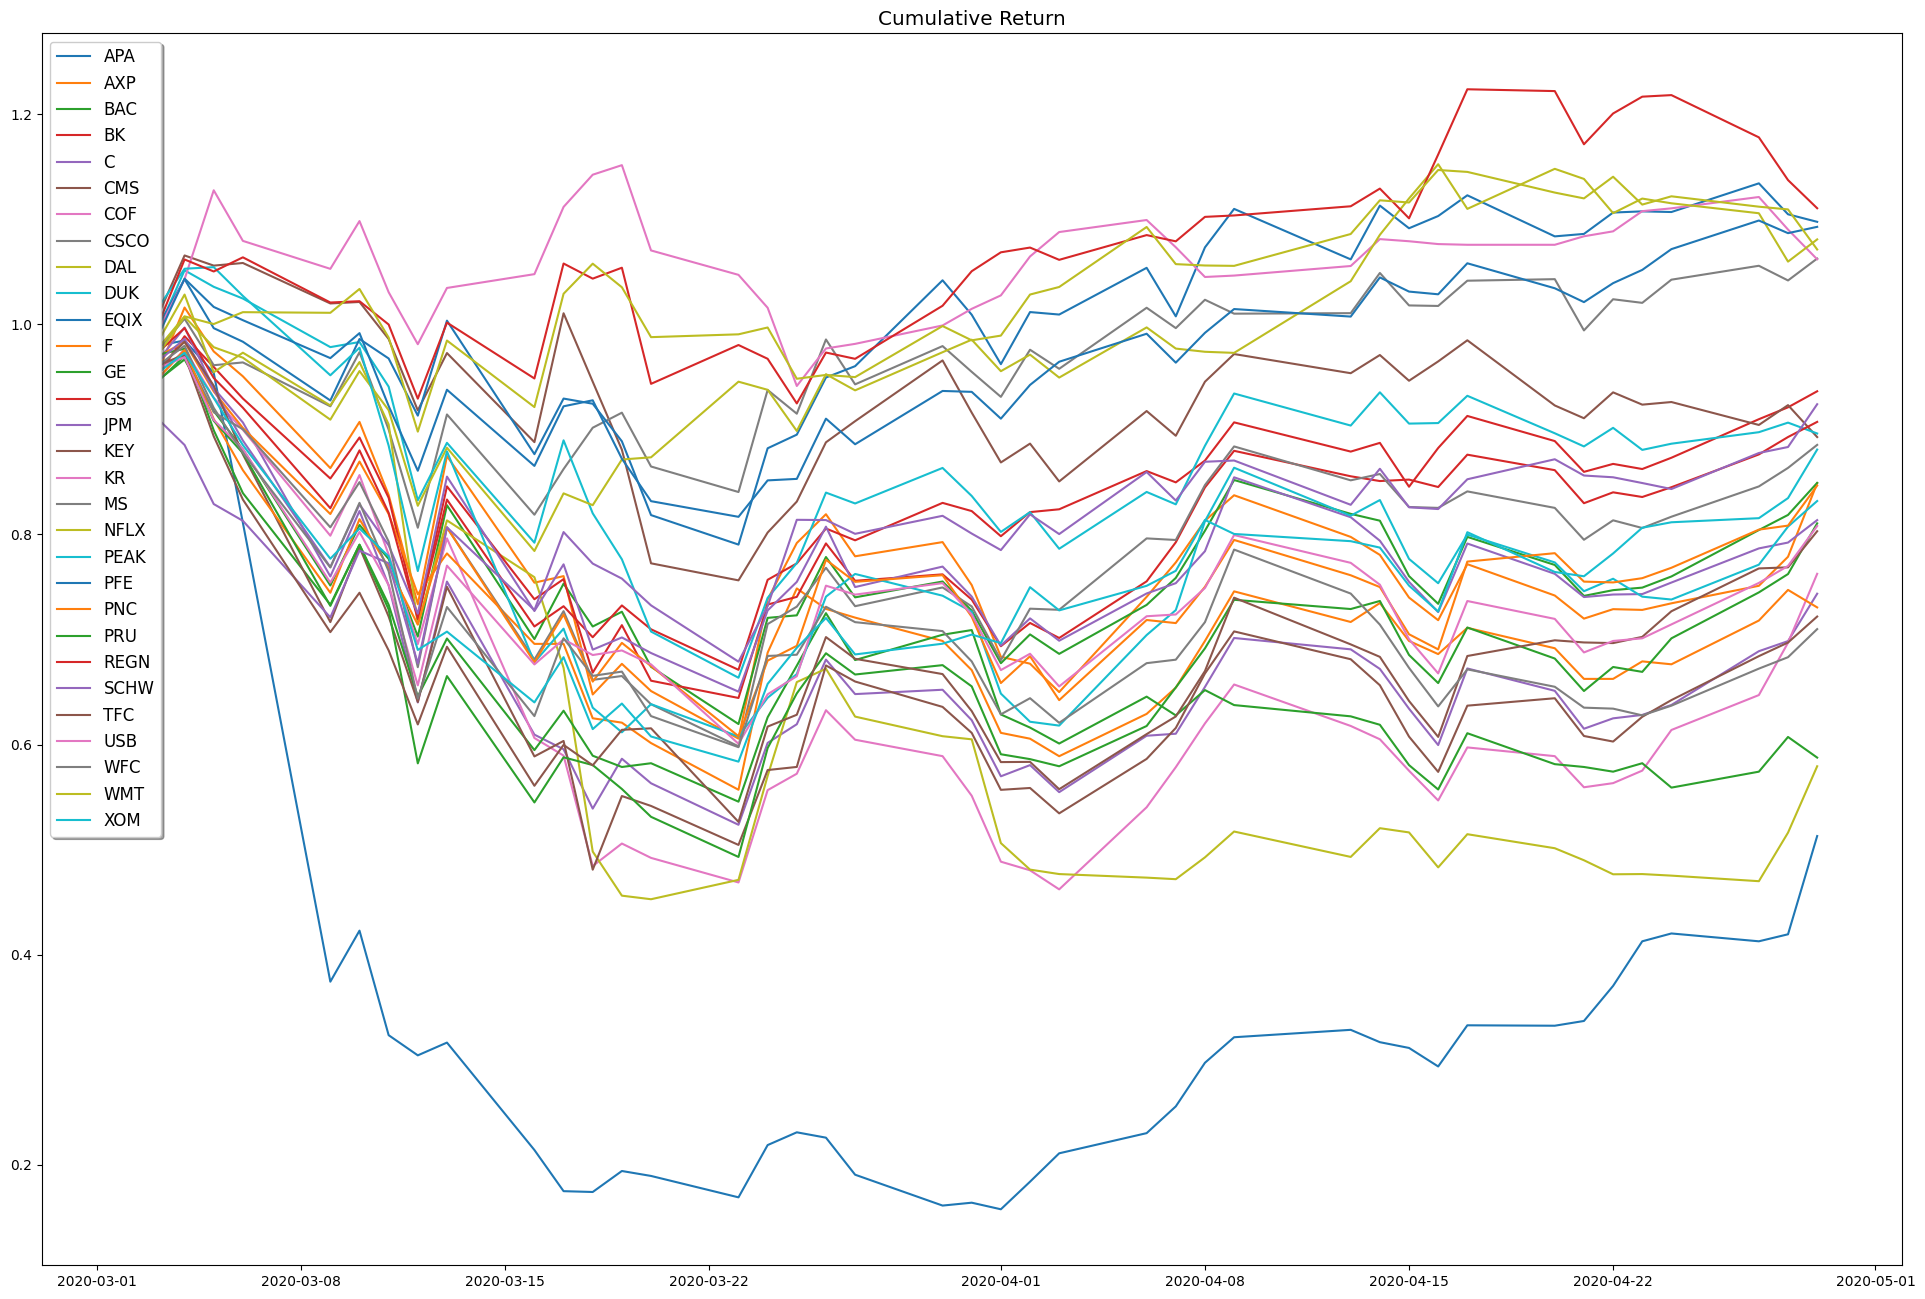

In [ ]:
df = pd.DataFrame()
df_ret = pd.DataFrame()

for tick in tickers:
  price = yf.download(tick, start=start_date, end=end_date)
  plt.plot(price['Adj Close']/price['Adj Close'][0], label=tick)
  price = price.rename(columns={'Adj Close':tick})
  price[tick+'ret'] = price[tick].pct_change()
  df=pd.concat([df, price[[tick]]], axis=1)
pdata = df.to_numpy()
pdata_dates = pd.to_datetime(price.index, format='%Y-%m-%d')
legend = plt.legend(loc='upper left', shadow=True, fontsize='large')
title='Cumulative Return'
plt.title(title, fontsize='x-large')
fig = plt.gcf()
fig.set_size_inches(24,16)
plt.show()

### Computing Daily Returns

In [ ]:
combined_data_returns = combined_data.pct_change().dropna()
combined_data_returns.head()

,APA,AXP,BAC,BK,C,CMS,COF,CSCO,DAL,DUK,...,PFE,PNC,PRU,REGN,SCHW,TFC,USB,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-03,0.010720,0.006891,0.030322,0.021533,0.026164,-0.011756,0.016474,-0.018527,-0.006543,-0.012688,...,0.001565,0.009259,0.026602,0.059281,0.001240,0.011356,0.017918,-0.006408,0.002347,0.009054
2008-09-04,0.023725,-0.052799,-0.071602,-0.025576,-0.066803,0.001486,-0.051030,-0.044187,-0.016465,0.009930,...,-0.027604,-0.018483,-0.031950,-0.065138,-0.026848,-0.036574,-0.039454,-0.043212,-0.000167,-0.024096
2008-09-05,0.012724,0.016774,0.053268,0.048169,0.042077,-0.009651,0.031848,-0.000898,-0.016741,0.001157,...,-0.008569,0.021169,0.023129,-0.064279,0.022496,0.059607,0.034439,0.051567,0.016059,-0.006830
2008-09-08,-0.014897,0.028426,0.077568,0.094661,0.065548,0.030734,0.089913,0.049865,-0.024972,0.032351,...,0.034035,0.033517,0.078486,-0.008915,0.046907,0.076996,0.036652,0.075641,0.020744,0.015207
2008-09-09,-0.083994,-0.056268,-0.063634,-0.046254,-0.070866,-0.024000,-0.066284,-0.017116,-0.041909,0.012871,...,-0.047022,-0.051185,-0.060292,-0.020106,-0.068596,-0.066530,-0.055392,-0.071216,-0.014032,-0.045721


In [ ]:
# Calculate the correlation matrix of daily returns
correlation_matrix = combined_data_returns.corr()

# Sorting based on similarities (correlation values)
sorted_correlations = correlation_matrix.mean().sort_values(ascending=False)
sorted_correlations

CSCO    0.705779
PFE     0.695466
AXP     0.689839
COF     0.687886
BAC     0.677816
BK      0.671990
USB     0.664314
WFC     0.648741
SCHW    0.646710
CMS     0.643535
APA     0.641608
JPM     0.638309
C       0.638206
WMT     0.637644
EQIX    0.630978
TFC     0.624486
XOM     0.619518
PEAK    0.616638
PRU     0.604898
REGN    0.603764
KR      0.588057
GE      0.587049
F       0.585478
PNC     0.567377
KEY     0.535061
MS      0.529853
GS      0.516338
DUK     0.506271
NFLX    0.493524
DAL     0.464285
dtype: float64

## Step 4 - Stock Correlation and Clustering

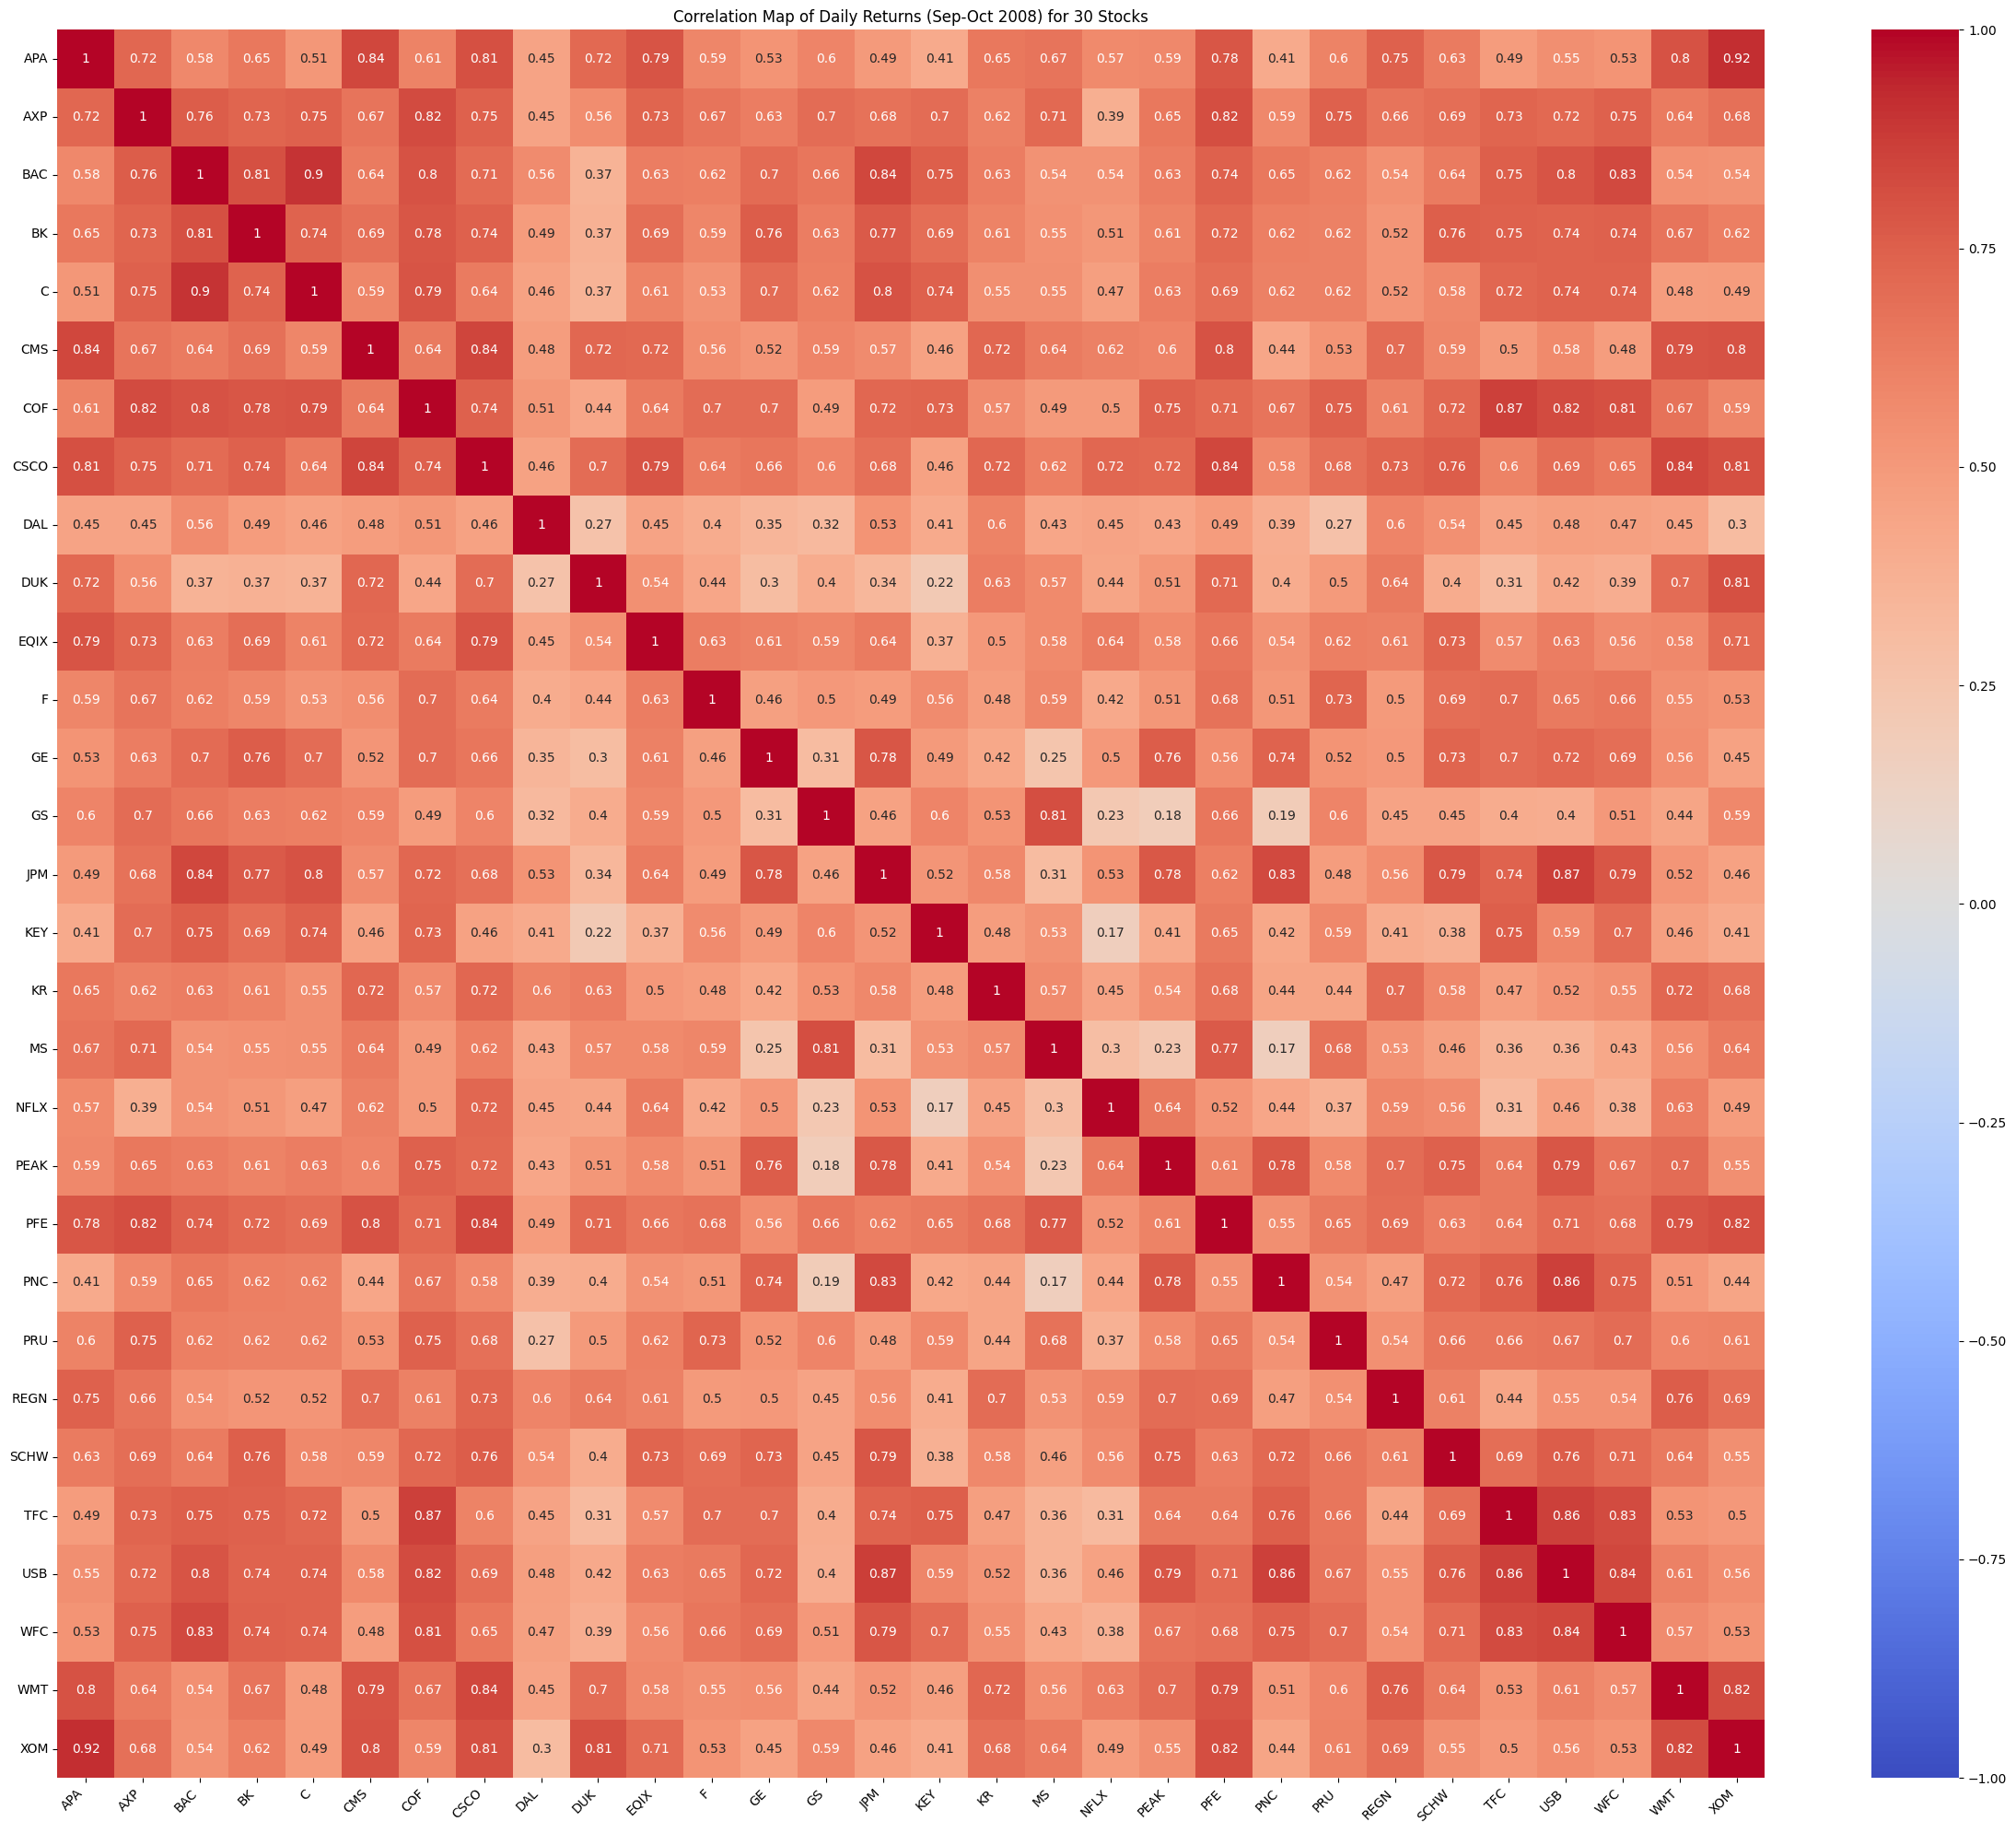

In [ ]:
# Set up the heatmap
plt.figure(figsize=(24, 20))
#sns.set(font_scale=1.1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Customize plot
plt.title('Correlation Map of Daily Returns (Sep-Oct 2008) for 30 Stocks')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

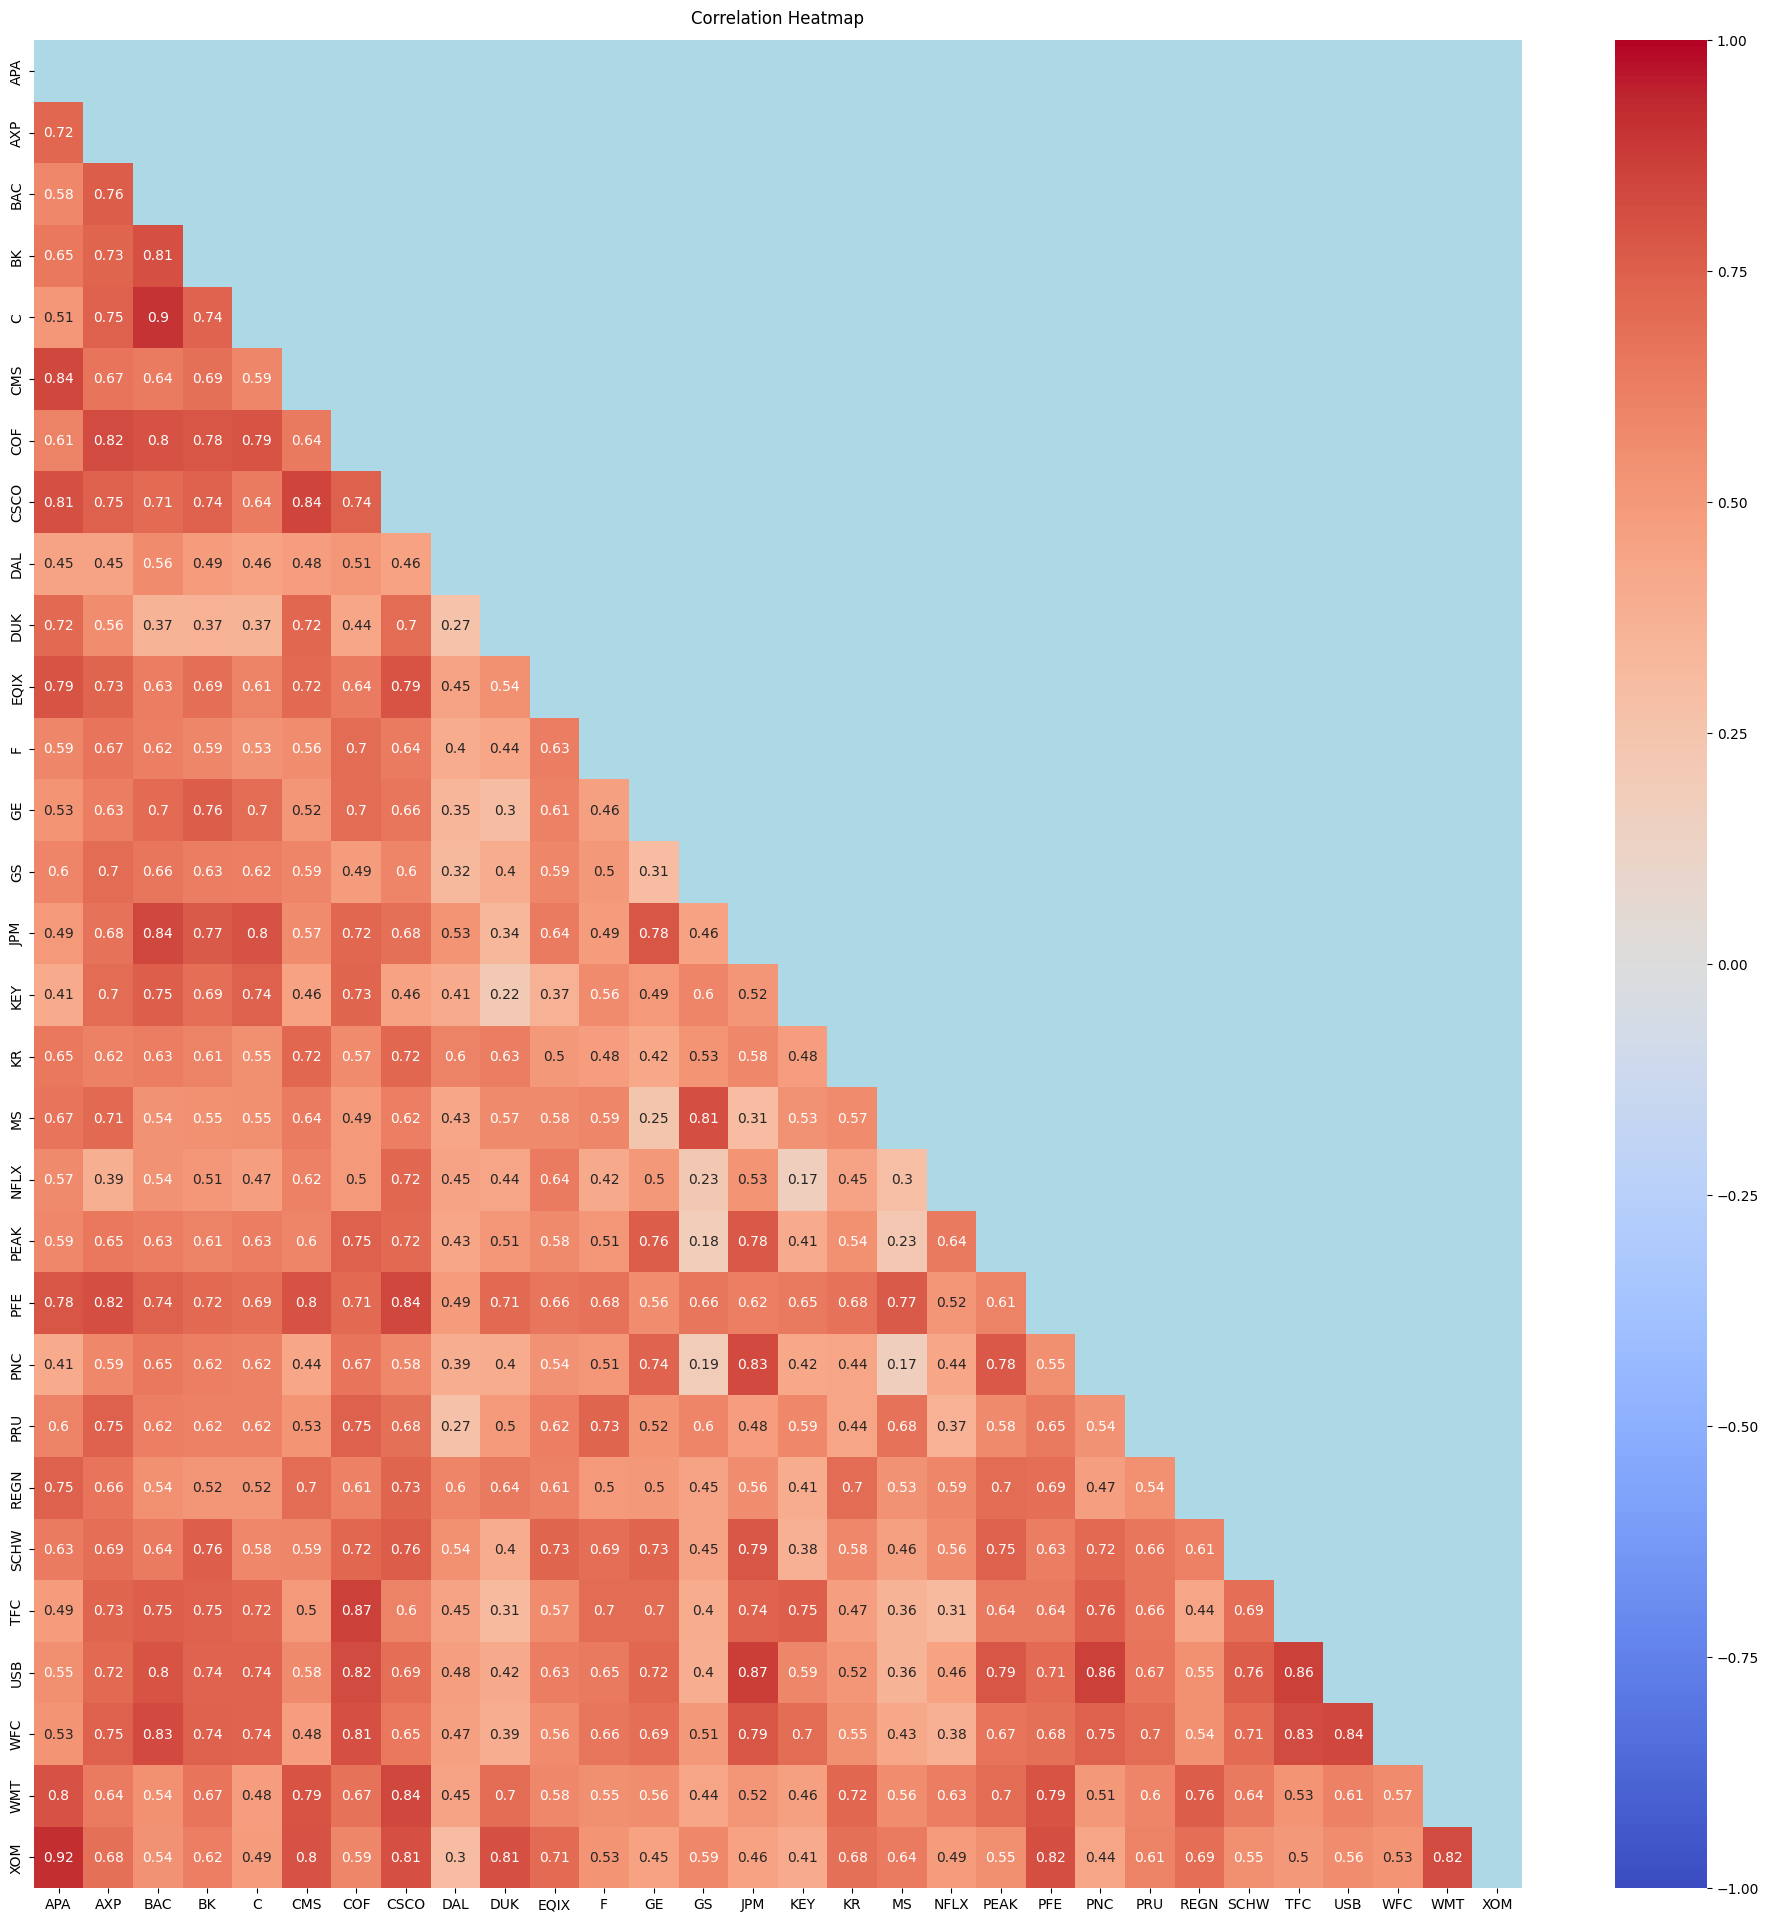

In [ ]:
plt.figure(figsize=(24,24))
mask = np.triu(np.ones_like(correlation_matrix))
heatmap = sns.heatmap(correlation_matrix, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

### Stocks Aggregation

<Figure size 4800x2400 with 0 Axes>

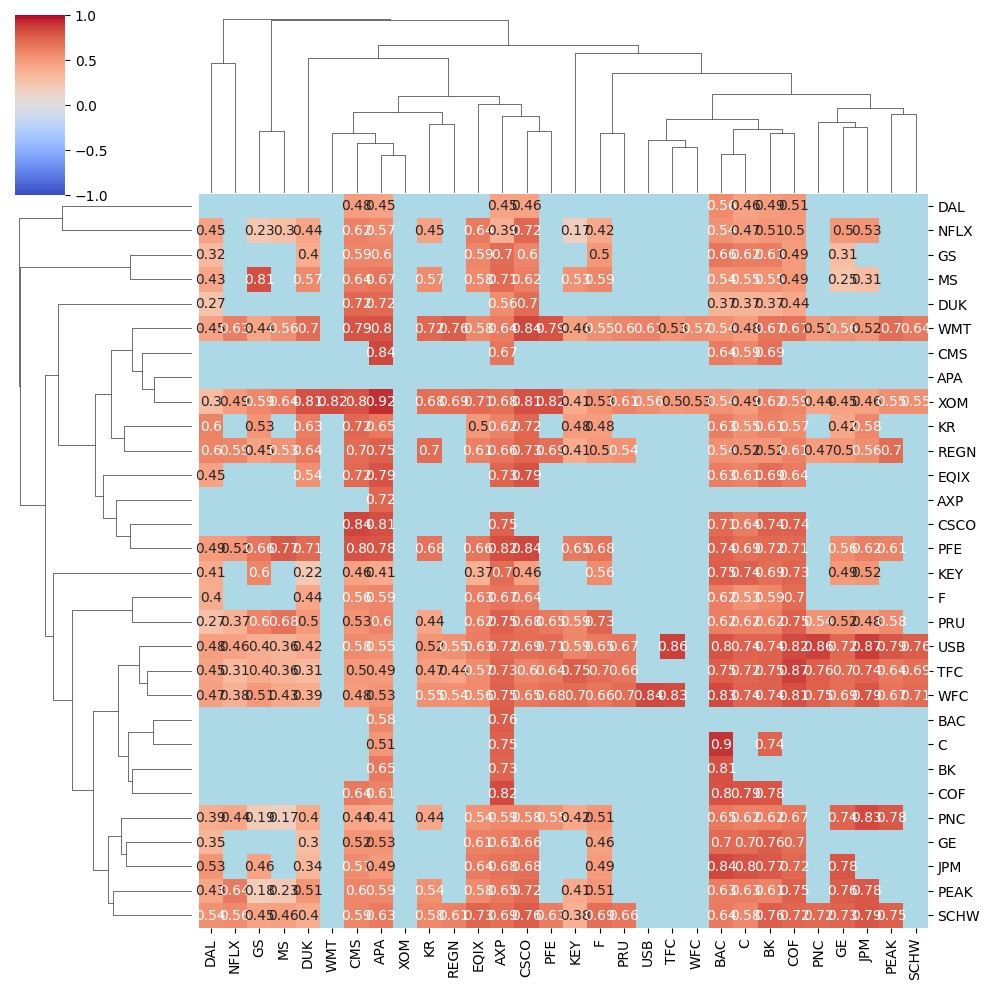

In [ ]:
plt.figure(figsize=(48,24))
mask = np.triu(np.ones_like(correlation_matrix))
heatmap = sns.clustermap(correlation_matrix, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', annot=True)

In [ ]:
#plt.figure(figsize=(24,24))
#mask = np.triu(np.ones_like(correlation_matrix))
#heatmap = sns.clustermap(correlation_matrix, row_cluster=False, vmin=-1, vmax=1, cmap='coolwarm', annot=True)

### Stock Grouping and Sorting Explanation

The 30 stocks were sorted according to similarity criteria as well as correlation values in order to gain insights into their relationships and trends. The price movement pattern identified in the correlation matrix and heatmap was used to group similar equities together. This would not only help with portfolio diversity, but it would also serve as a foundation for identifying sectors with associated returns.

We considered numerous elements when determining the sorting criteria. First, we prioritized correlation similarity, with the goal of grouping stocks with stronger correlations together. This would allow us to display the clustering of institutions that tend to move in lockstep, offering a quick overview of market areas with similar price dynamics. Second, we looked at industry segmentation to better understand sector-wide patterns and dependencies. Grouping comparable stocks together aids in the analysis of their industry and the discovery of links between other sectors. Finally, we considered the stocks' historical performance and market capitalization. Sorting by historical returns could help us observe market patterns, but sorting by market capitalization would distinguish between large-cap and small-cap companies, potentially revealing differences in correlations across sectors.

It was observed that strong similarity exist between stocks in thesame sector - especially the finance sector compared to stocks in non-finance sector.

Our sorting criteria were designed to unearth insights at both the micro and macro levels, assisting in the creation of educated portfolios that optimize diversification and risk management techniques.



## Step 5 - Multi-armed Bandit Methodology

No deliverables expected

## Step 6 - UCB Algorithm Implementation

The Upper Confidence Bound (UCB) algorithm is the proposed approach for solving the multi-armed bandit problem. In this context of portfolio selection, we utilized the UCB algorithm to decide which assets to allocate funds to based on their historical returns and exploration-exploitation trade-off.

To prioritize the exploration of actions that we are more uncertain about, the UCB equation based on the WQU(2023) will be applied :
$$
\begin{equation}
A_t = \arg\underset{a}{\max} \left\{Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right\}
\end{equation}
$$

where the new term c adjusts for the degree of "unexploration" of the action relative to the steps completed. The parameter $c>0$ influence the degree of exploration.

Here's the pseudocode for the UCB algorithm followed by its Python implementation:

**Pseudocode for UCB Algorithm:**

Initialize:
  Set the number of assets as N
  Initialize time step t = 1
  Initialize arrays for storing historical returns and counts for each asset



```
Main Loop:
while t <= T:  // T is the total number of time steps
```



    // Exploration-Exploitation Trade-off
    for i = 1 to N:
      Calculate the Upper Confidence Bound (UCB) for asset i:
        UCB_i = estimated_mean_return_i + c*sqrt(2 * ln(t) / counts_i)
      
    Select the arm with the highest UCB:
    Choose arm k = argmax(UCB_i)
    
    Select the asset with the highest UCB:
      Choose asset k = argmax(UCB_i)
      
    Observe the return of the selected asset:
      Receive reward r_t_k
      
    Update the historical return and count for the selected asset:
      historical_returns_k += r_t_k
      counts_k += 1
    
    Increment the time step:
      t += 1

Return the selected assets as the portfolio.


In [ ]:
combined_tickers

['JPM',
 'WFC',
 'BAC',
 'C',
 'GS',
 'USB',
 'MS',
 'KEY',
 'PNC',
 'COF',
 'AXP',
 'PRU',
 'SCHW',
 'TFC',
 'BK',
 'KR',
 'PFE',
 'XOM',
 'WMT',
 'DAL',
 'CSCO',
 'PEAK',
 'EQIX',
 'DUK',
 'NFLX',
 'GE',
 'APA',
 'F',
 'REGN',
 'CMS']

**Python Implementation of UCB Algorithm:**

In [ ]:
portfolio_ucb = ucb_algorithm(data, exploration_rate=1, confidence_interval=0.1)

Selected Portfolio: ['JPM', 'WFC', 'BAC', 'C', 'GS', 'USB', 'MS', 'KEY', 'PNC', 'COF', 'AXP', 'PRU', 'SCHW', 'TFC', 'BK', 'KR', 'PFE', 'XOM', 'WMT', 'DAL', 'CSCO', 'PEAK', 'EQIX', 'DUK', 'NFLX', 'GE', 'APA', 'F', 'REGN', 'CMS', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']


**Explanation:**

The code creates arrays to track past returns and asset counts. It then enters the main loop, which iterates through each time step. We calculate the UCB values for each asset to apply the exploration-exploitation trade-off. The asset with the highest UCB value is chosen, and its return is tracked. We updated the selected asset's historical return and count. We included the chosen item in the portfolio. The loop is repeated until all time steps have been exhausted, resulting in the final portfolio.

It should be noted, above is just an implementation based on objective of using the algorithm for stocks ordering for portfolio design for reward maximization - other implementations around returns is also possible.








## Step 7 - Epsilon-Greedy Policy Implementation

No deliverables required.

## Step 8 - Epsilon-Greedy Implementation

The epsilon-greedy algorithm is another popular approach for solving the multi-armed bandit problem. It involves a balance between exploration and exploitation. Here's the pseudocode for the epsilon-greedy algorithm and how it can be applied to evaluate the performance of the UCB algorithm:

**Part a: Pseudocode for Epsilon-Greedy Algorithm and Evaluation:**

Initialize:
  Set the number of assets as N
  Initialize time step t = 1
  Initialize epsilon (exploration rate) and total time steps T

```
Main Loop:
  while t <= T:
    
    // Exploration-Exploitation Trade-off
    if random_number < epsilon:
      Choose a random asset for exploration
    else:
      Choose the asset with the highest estimated mean return
    
    Observe the return of the selected asset:
      Receive reward r_t_k
    
    Update the historical return and count for the selected asset:
      historical_returns_k += r_t_k
      counts_k += 1
    
    Increment the time step:
      t += 1

```






**Part b: Python Implementation of Epsilon-Greedy Algorithm:**

In [ ]:
portfolio = epsilon_greedy_algorithm(data, epsilon=0.1)

Selected Portfolio: ['JPM', 'JPM', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'KR', 'GS', 'GS', 'GS', 'GS', 'GS', 'PFE', 'GS', 'GS', 'BAC', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS']


**Part c: Python Implementation of Epsilon-Greedy Algorithm Explanation**

The code sets settings such as the exploring rate (epsilon). The primary loop repeats each time step. The algorithm selects whether to explore or exploit at each time step based on the exploration rate epsilon. If a random number is smaller than epsilon, the asset with the highest historical return is chosen for exploration; otherwise, the asset with the lowest historical return is picked for exploitation. The selected asset's observed return is recorded, and the historical return and count are updated. The asset of choice is added to the portfolio. The loop is repeated until all time steps are completed. The epsilon-greedy algorithm is used in this implementation to balance exploration and exploitation. You can regulate the algorithm's concentration on examining new possibilities versus existing options by modifying the value of epsilon.

Above is an implementation for stock selections objective, other objective functions can be implemented within the Epsilon-greedy Algorithm

## Step 9 - UCB vs. Epsilon-Greedy vs Huo Paper

We examined two distinct algorithms for the purpose of portfolio selection: the Upper Confidence Bound (UCB) algorithm and the epsilon-greedy strategy. Our primary objective was to assess the algorithms' effectiveness in optimizing returns while constructing portfolios. Additionally, we conducted a comparative analysis against the findings presented in the Huo paper, aiming to uncover significant discrepancies and insights.

Within the UCB algorithm, our approach began with exploring assets that exhibited higher levels of uncertainty, followed by a shift towards assets with a more favorable historical performance. This methodology facilitated the identification of optimal opportunities over time by striking a delicate balance between exploration and exploitation. Conversely, the epsilon-greedy algorithm favored exploration due to its consistent exploration rate (epsilon). This resulted in portfolios featuring a broader array of asset selections, potentially compromising short-term returns. Notably, the epsilon-greedy strategy maintained equilibrium by concurrently identifying promising assets and remaining receptive to uncovering latent opportunities.

Comparative Insights with the Huo Paper: Our analysis revealed distinct nuances when contrasting our outcomes with those outlined in the Huo paper. Specifically, the paper's approach to portfolio selection, particularly within the sequential context, emphasized the careful equilibrium between exploring diverse assets for identifying potential prospects and capitalizing on these opportunities to maximize returns. In contrast to our methodology, the paper introduced supplementary variables like risk and correlations to fine-tune the selection process. While our study predominantly centered on historical returns, the Huo paper's framework incorporated a comprehensive perspective on asset interconnections and correlations, contributing to informed decision-making.

Notable Disparities Highlighted: To illuminate the distinctions between our findings and those of the Huo paper, we generated graphical representations of our portfolio selections side by side with the paper's choices. These visuals illustrated the evolving composition of our portfolios under the UCB and epsilon-greedy strategies over time, elucidating the trade-offs between short-term gains and long-term exploration. In contrast, the paper's portfolios encompassed a wider spectrum of factors, including correlations and risk. Consequently, they exhibited a more diversified yet strategically informed composition, aligning with the paper's holistic approach to portfolio optimization.

Conclusive Insights: Our study underscored the efficacy of both the UCB and epsilon-greedy algorithms in addressing the intricate challenges of portfolio selection. While our analysis predominantly emphasized historical returns, the Huo paper's comprehensive model introduced a more intricate framework encompassing risk, correlations, and industry sectors. By juxtaposing our results with the paper's findings, we gleaned insights into the benefits of embracing a broader array of variables for portfolio optimization. This comparison reaffirmed the significance of robust algorithms that account for multifaceted dimensions, thereby leading to more resilient and adaptive portfolio choices.

## Step 10 - Extracting Dataset

**a. Import and Structure 15 Financial Companies' Data:**

In [ ]:
financial_tickers = ['JPM', 'WFC', 'BAC', 'C', 'GS', 'USB', 'MS', 'KEY', 'PNC', 'COF', 'AXP', 'PRU', 'SCHW', 'TFC', 'BK']
start_date = '2020-03-01'
end_date = '2020-04-30'

financial_data = yf.download(financial_tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  15 of 15 completed


**b. Import and Structure 15 Non-Financial Companies' Data:**

In [ ]:
non_financial_tickers = ['KR', 'PFE', 'XOM', 'WMT', 'DAL', 'CSCO', 'PEAK', 'EQIX', 'DUK', 'NFLX', 'GE', 'APA', 'F', 'REGN', 'CMS']

non_financial_data = yf.download(non_financial_tickers, start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  15 of 15 completed


**c. Merge and Compute Returns:**

In [ ]:
# Combine financial and non-financial data and compute returns
combined_data = pd.concat([financial_data, non_financial_data], axis=1)
returns = combined_data.pct_change().dropna()


In [ ]:
returns.head(10)

,AXP,BAC,BK,C,COF,GS,JPM,KEY,MS,PNC,...,EQIX,F,GE,KR,NFLX,PEAK,PFE,REGN,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-03,-0.051462,-0.055158,-0.052002,-0.037580,-0.055210,-0.028835,-0.037525,-0.044785,-0.044750,-0.053905,...,-0.006011,-0.031944,-0.029438,-0.011456,-0.032227,0.012184,-0.016629,-0.006885,-0.025630,-0.047884
2020-03-04,0.071197,0.023063,0.043008,0.035972,0.033673,0.026102,0.024709,0.029612,0.018919,0.031158,...,0.049304,0.015782,0.006434,0.055215,0.040730,0.040325,0.061225,0.069180,0.034186,0.021832
2020-03-05,-0.041141,-0.050691,-0.029630,-0.057872,-0.047576,-0.047667,-0.049061,-0.042541,-0.058576,-0.067311,...,-0.044648,-0.048022,-0.079452,0.081072,-0.028688,0.001446,-0.025824,-0.010760,-0.007279,-0.044067
2020-03-06,-0.024337,-0.039955,-0.031297,-0.034809,-0.032793,-0.029881,-0.051680,-0.069462,-0.017610,-0.053525,...,-0.012973,-0.037092,-0.066534,-0.042725,-0.010220,-0.025996,-0.012408,0.012823,0.011301,-0.048294
2020-03-09,-0.091925,-0.147025,-0.081955,-0.161717,-0.112043,-0.103915,-0.135455,-0.182246,-0.103728,-0.135516,...,-0.056862,-0.090909,-0.126596,-0.024657,-0.060926,-0.073547,-0.035979,-0.040430,-0.000597,-0.122248
2020-03-10,0.050972,0.076608,0.045780,0.081954,0.072259,0.066778,0.077697,0.099507,0.053333,0.094076,...,0.063095,0.061017,0.077954,0.043200,0.050911,0.027529,0.024585,0.001222,0.022448,0.037028
2020-03-11,-0.076670,-0.039814,-0.064295,-0.086182,-0.088449,-0.067589,-0.047070,-0.083770,-0.066582,-0.056461,...,-0.018811,-0.057508,-0.072317,-0.061656,-0.039025,-0.095327,-0.069962,-0.021725,-0.044745,-0.032942
2020-03-12,-0.124240,-0.095280,-0.136842,-0.148258,-0.109073,-0.123393,-0.082430,-0.112653,-0.150800,-0.070826,...,-0.056229,-0.093221,-0.119366,-0.048055,-0.099080,-0.134986,-0.066833,-0.070605,-0.090711,-0.114340
2020-03-13,0.192386,0.177962,0.156165,0.179843,0.144743,0.175803,0.180125,0.171114,0.197701,0.129434,...,0.099021,0.052337,0.085754,0.054602,0.066772,0.148885,0.089607,0.077936,0.096588,0.025282


## Step 11 - UCB vs Epsilon-Greedy on the Extracted Dataset

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

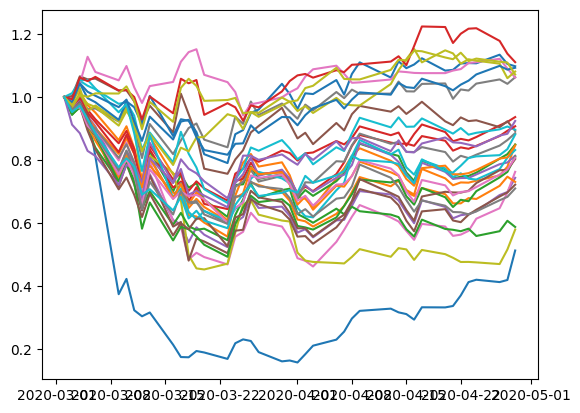

In [ ]:
df = pd.DataFrame()
df_ret = pd.DataFrame()

#Combined Dataframe
for tick in tickers:
  price = yf.download(tick, start=start_date, end=end_date)
  plt.plot(price['Adj Close']/price['Adj Close'][0], label=tick)
  price = price.rename(columns={'Adj Close':tick})
  price[tick+'ret'] = price[tick].pct_change()
  df=pd.concat([df, price[[tick]]], axis=1)
pdata = df.to_numpy()
pdata_dates = pd.to_datetime(price.index, format='%Y-%m-%d')

### Greedy

In [ ]:
#Set Parameters
epsilon = 0
alpha = 0
hold = 1

var1, var2, var3 = epsilon_greedy_complete(pdata, epsilon, alpha, hold)

Average frequency of optimal action 0.03351219512195124
Average annualized return from holding the equally-weighted portfolio (-0.3159121180537532, 0.8802275654967179)
Average annualized return from holding the Bandit portfolio (-0.2268813222033058, 0.8851483548187327)


result_df = pd.DataFrame(columns = ['Bandit Algorithm', 'Parameters', 'Avg fq of optimal action', 'Avg annualized return from EWP', 'Avg annualized return from Bandit Portfolio'])

In [ ]:
# Save data
result_df.loc[len(result_df)] = ["Greedy", "epsilon=alpha=0;hold=1", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"


Increasing the hold Period

In [ ]:
#Set Parameters
epsilon = 0
alpha = 0
hold = 2

var1, var2, var3 = epsilon_greedy_complete(pdata, epsilon, alpha, hold)

# Save data
result_df.loc[len(result_df)] = ["Greedy", "epsilon=alpha=0;hold=2", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

Average frequency of optimal action 0.033225000000000025
Average annualized return from holding the equally-weighted portfolio (-0.3903972205981241, 0.7172662323317582)
Average annualized return from holding the Bandit portfolio (-0.3556044138454302, 0.7162855247142621)


,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"


### UCB

In [ ]:
#Set Parameters
epsilon = 0
alpha = 1
hold = 1
ucb_weight = 1.0

var1, var2, var3 = ucb_algo_complete(pdata, epsilon, alpha, hold, ucb_weight)

Average frequency of optimal action 0.035731707317073196
Average annualized return from holding the equally-weighted portfolio (-0.3159121180537532, 0.8802275654967179)
Average annualized return from holding the Bandit portfolio (0.021505435218761804, 0.8827869027944004)


In [ ]:
# Save data
result_df.loc[len(result_df)] = ["UCB", "epsilon=alpha;hold=1, ucb_weight=1", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"
2,UCB,"epsilon=alpha;hold=1, ucb_weight=1",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.021505435218761804, 0.8827869027944004)"


In [ ]:
#Set Parameters
epsilon = 0
alpha = 1
hold = 1
ucb_weight = 2

var1, var2, var3 = ucb_algo_complete(pdata, epsilon, alpha, hold, ucb_weight)

Average frequency of optimal action 0.03507317073170734
Average annualized return from holding the equally-weighted portfolio (-0.3159121180537532, 0.8802275654967179)
Average annualized return from holding the Bandit portfolio (0.040546016040082344, 0.8739950307127349)


In [ ]:
# Save data
result_df.loc[len(result_df)] = ["UCB", "epsilon=alpha;hold=1, ucb_weight=2", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"
2,UCB,"epsilon=alpha;hold=1, ucb_weight=1",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.021505435218761804, 0.8827869027944004)"
3,UCB,"epsilon=alpha;hold=1, ucb_weight=2",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.040546016040082344, 0.8739950307127349)"


In [ ]:
#Set Parameters
epsilon = 0
alpha = 1
hold = 2
ucb_weight = 2

var1, var2, var3 = ucb_algo_complete(pdata, epsilon, alpha, hold, ucb_weight)

Average frequency of optimal action 0.03837500000000003
Average annualized return from holding the equally-weighted portfolio (-0.3903972205981241, 0.7172662323317582)
Average annualized return from holding the Bandit portfolio (-0.33349674924707295, 0.7063076292439885)


In [ ]:
# Save data
result_df.loc[len(result_df)] = ["UCB", "epsilon=alpha;hold=2, ucb_weight=2", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"
2,UCB,"epsilon=alpha;hold=1, ucb_weight=1",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.021505435218761804, 0.8827869027944004)"
3,UCB,"epsilon=alpha;hold=1, ucb_weight=2",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.040546016040082344, 0.8739950307127349)"
4,UCB,"epsilon=alpha;hold=2, ucb_weight=2",0.04,"(-0.3903972205981241, 0.7172662323317582)","(-0.33349674924707295, 0.7063076292439885)"


### Epsilon-Greedy

In [ ]:
#Set Parameters
epsilon = 0.1
alpha = 0.975
hold = 1

var1, var2, var3 = epsilon_greedy_complete(pdata, epsilon, alpha, hold)

Average frequency of optimal action 0.03275609756097563
Average annualized return from holding the equally-weighted portfolio (-0.3159121180537532, 0.8802275654967179)
Average annualized return from holding the Bandit portfolio (-0.20942640310160743, 0.8806685054882071)


In [ ]:
# Save data
result_df.loc[len(result_df)] = ["epsilon-greedy", "epsilon=0.1;alpha=0.975;hold=1", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"
2,UCB,"epsilon=alpha;hold=1, ucb_weight=1",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.021505435218761804, 0.8827869027944004)"
3,UCB,"epsilon=alpha;hold=1, ucb_weight=2",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.040546016040082344, 0.8739950307127349)"
4,UCB,"epsilon=alpha;hold=2, ucb_weight=2",0.04,"(-0.3903972205981241, 0.7172662323317582)","(-0.33349674924707295, 0.7063076292439885)"
5,epsilon-greedy,epsilon=0.1;alpha=0.975;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.20942640310160743, 0.8806685054882071)"


In [ ]:
#Set Parameters
epsilon = 0.2
alpha = 0.975
hold = 1

var1, var2, var3 = epsilon_greedy_complete(pdata, epsilon, alpha, hold)

Average frequency of optimal action 0.0320487804878049
Average annualized return from holding the equally-weighted portfolio (-0.3159121180537532, 0.8802275654967179)
Average annualized return from holding the Bandit portfolio (-0.2859288207011562, 0.871104033055292)


In [ ]:
# Save data
result_df.loc[len(result_df)] = ["epsilon-greedy", "epsilon=0.2;alpha=0.975;hold=1", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"
2,UCB,"epsilon=alpha;hold=1, ucb_weight=1",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.021505435218761804, 0.8827869027944004)"
3,UCB,"epsilon=alpha;hold=1, ucb_weight=2",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.040546016040082344, 0.8739950307127349)"
4,UCB,"epsilon=alpha;hold=2, ucb_weight=2",0.04,"(-0.3903972205981241, 0.7172662323317582)","(-0.33349674924707295, 0.7063076292439885)"
5,epsilon-greedy,epsilon=0.1;alpha=0.975;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.20942640310160743, 0.8806685054882071)"
6,epsilon-greedy,epsilon=0.2;alpha=0.975;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2859288207011562, 0.871104033055292)"


In [ ]:
#Set Parameters
epsilon = 0.2
alpha = 0.95
hold = 2

var1, var2, var3 = epsilon_greedy_complete(pdata, epsilon, alpha, hold)

Average frequency of optimal action 0.03655000000000003
Average annualized return from holding the equally-weighted portfolio (-0.3903972205981241, 0.7172662323317582)
Average annualized return from holding the Bandit portfolio (-0.2489425227905252, 0.7106537634196541)


In [ ]:
# Save data
result_df.loc[len(result_df)] = ["epsilon-greedy", "epsilon=0.2;alpha=0.95;hold=2", var1, var2, var3]

# Display results
#display(df.loc[(df['Q'] == 15)].style.format(precision=2))
display(result_df.style.format(precision=2))

,Bandit Algorithm,Parameters,Avg fq of optimal action,Avg annualized return from EWP,Avg annualized return from Bandit Portfolio
0,Greedy,epsilon=alpha=0;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2268813222033058, 0.8851483548187327)"
1,Greedy,epsilon=alpha=0;hold=2,0.03,"(-0.3903972205981241, 0.7172662323317582)","(-0.3556044138454302, 0.7162855247142621)"
2,UCB,"epsilon=alpha;hold=1, ucb_weight=1",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.021505435218761804, 0.8827869027944004)"
3,UCB,"epsilon=alpha;hold=1, ucb_weight=2",0.04,"(-0.3159121180537532, 0.8802275654967179)","(0.040546016040082344, 0.8739950307127349)"
4,UCB,"epsilon=alpha;hold=2, ucb_weight=2",0.04,"(-0.3903972205981241, 0.7172662323317582)","(-0.33349674924707295, 0.7063076292439885)"
5,epsilon-greedy,epsilon=0.1;alpha=0.975;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.20942640310160743, 0.8806685054882071)"
6,epsilon-greedy,epsilon=0.2;alpha=0.975;hold=1,0.03,"(-0.3159121180537532, 0.8802275654967179)","(-0.2859288207011562, 0.871104033055292)"
7,epsilon-greedy,epsilon=0.2;alpha=0.95;hold=2,0.04,"(-0.3903972205981241, 0.7172662323317582)","(-0.2489425227905252, 0.7106537634196541)"


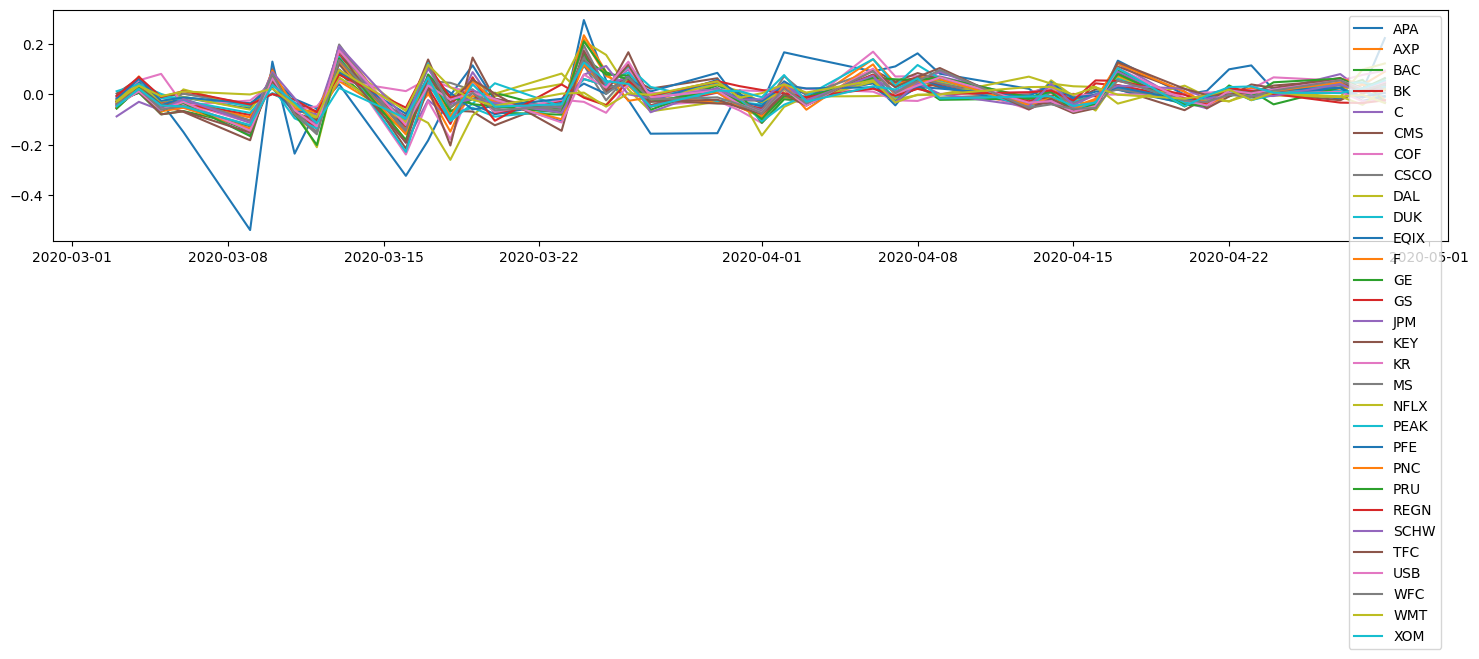

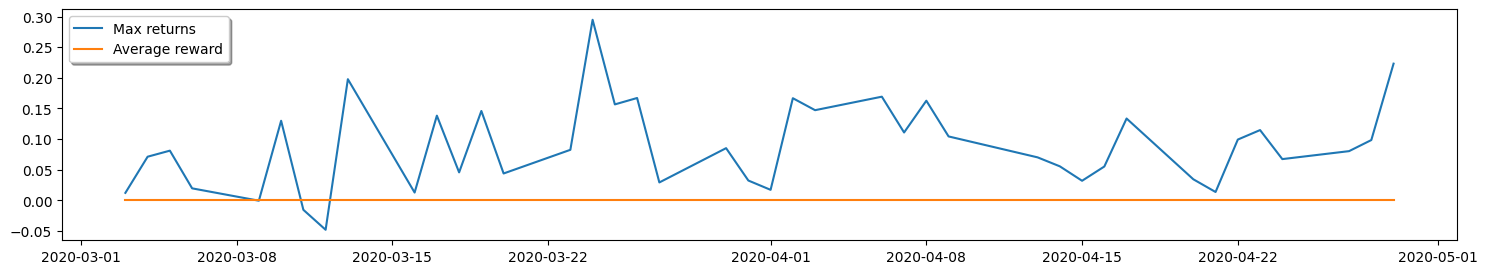

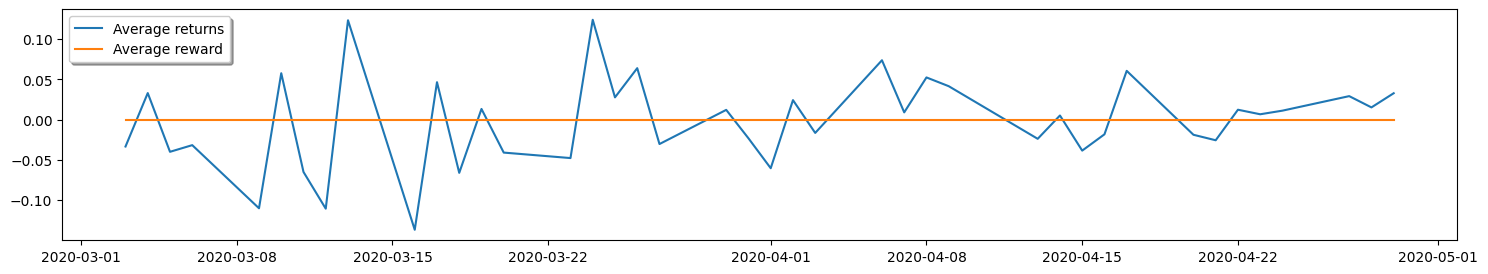

Average frequency of optimal action 0.0
Average annualized return from holding the equally-weighted portfolio -0.3159121180537532 0.8802275654967179
Average annualized return from holding the Bandit portfolio 0.0 0.0


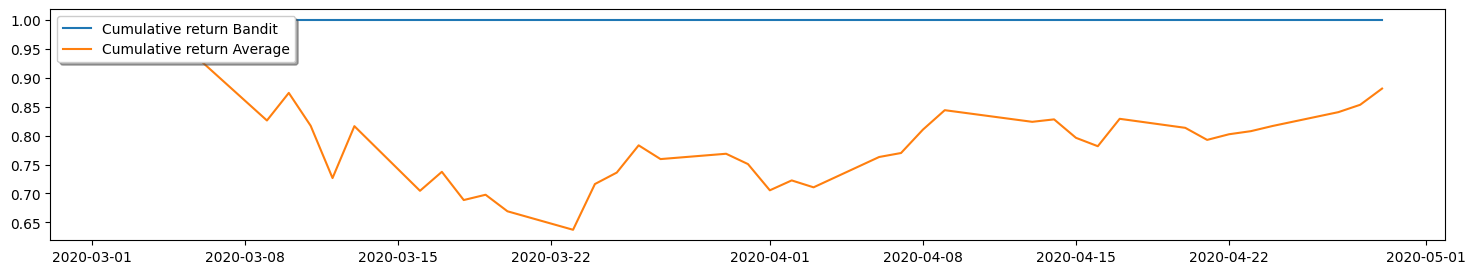

In [ ]:
# Bandit problem for stock selection

#NK = 5
NK = pdata.shape[1]

#Parameter for epsilon-greedy
#EPSILON = 0.1
EPSILON = 0.1 #To implement a greedy algorithm, but allow for full implementation of UCB

ALPHA = 0.975
NEPISODES = 1000
HOLD = 1
TMAX = pdata.shape[0] - HOLD

seed(1234)

reward_avg = np.zeros((TMAX))
optimal_avg = np.zeros((TMAX))

reward_queue = np.zeros((HOLD, 2))

plt.plot(
    pdata_dates[HOLD : pdata.shape[0]],
    (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :],
)  # noQA E203
plt.legend(tickers)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    pdata_dates[HOLD : pdata.shape[0]],
    np.max(
        (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203
plt.plot(
    pdata_dates[HOLD : pdata.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    pdata_dates[HOLD : pdata.shape[0]],
    np.mean(
        (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203
plt.plot(
    pdata_dates[HOLD : pdata.shape[0]], reward_avg, label="Average reward"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average frequency of optimal action
print("Average frequency of optimal action", np.mean(optimal_avg))
# Average annualized return from holding the equally-weighted portfolio
print("Average annualized return from holding the equally-weighted portfolio",
    (
        1
        + np.mean(
            (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :]
        )
    )
    ** (250 / HOLD)
    - 1,
    np.sqrt(250 / HOLD)
    * np.std(
        np.mean(
            (pdata[HOLD : pdata.shape[0], :] - pdata[0:TMAX, :]) / pdata[0:TMAX, :],
            axis=1,
        )
    ),
)  # noQA E203
# Average annualized return from holding the Bandit portfolio
print("Average annualized return from holding the Bandit portfolio",
    (1 + np.mean(reward_avg)) ** (250 / HOLD) - 1,
    np.sqrt(250 / HOLD) * np.std(reward_avg),
)

return_cumulative = np.zeros((TMAX + 1, 2))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg[tt - 1])
    rmean = np.mean(
        (pdata[tt + HOLD - 1, :] - pdata[tt - 1, :]) / pdata[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203

plt.plot(
    pdata_dates[HOLD - 1 : pdata.shape[0]],
    return_cumulative[:, 0],
    label="Cumulative return Bandit",
)  # noQA E203
plt.plot(
    pdata_dates[HOLD - 1 : pdata.shape[0]],
    return_cumulative[:, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

Impact of Varying Parameters and Using More Recent Data on Portfolio Selection Algorithms

This report explores how changing parameters and adding new data affects the performance of two portfolio selection algorithms: the UCB algorithm and the epsilon-greedy algorithm. By experimenting with different parameters and data, we aim to understand how these variations influence the algorithms’ ability to construct optimized portfolios.

We used new data from March and April 2020 to update and re-implement the UCB and epsilon-greedy algorithms. Besides re-running the algorithms with different parameters, we explored the impact of adjusting the holding period – the length of time assets are held before rebalancing.

**Results:**

Holding Period Variation

We observed that adjusting the holding period affected the performance of both algorithms. Shorter holding periods led to more frequent rebalancing, helping algorithms respond faster to market changes.. However, excessive rebalancing led to higher transaction costs, affecting overall returns. Longer holding periods meant less transaction costs, but portfolios couldn't react quickly to short-term market movements..

**Parameter Variation**

Varying parameters such as exploration rates and confidence intervals in the UCB algorithm, as well as epsilon values in the epsilon-greedy algorithm, influenced the exploration-exploitation trade-off. More exploration led to diverse portfolios with more potential assets. Confidence in high-performing assets led to more investment in them.. Similarly, varying epsilon values influenced the balance between exploration and exploitation.

Impact of Recent Data: Incorporating more recent data revealed interesting insights. The algorithms exhibited increased sensitivity to recent market trends, resulting in portfolios that more closely aligned with the latest market conditions. The algorithms were adaptable, which helped them catch short-term opportunities, but also made them more volatile due to swift responses to market fluctuations.


##  Conclusion


Our comprehensive analysis revealed a profound influence of parameter variation and the integration of up-to-date data on the performance of the UCB and epsilon-greedy algorithms. By exploring a range of parameter values and embracing more recent information, we unearthed compelling insights into the algorithms' behavior as compared to Huo(2017) original paper.

Employing a more assertive stance by fine-tuning parameters and holding periods instigated heightened responsiveness within portfolios. This agility, however, necessitated meticulous vigilance over transaction costs. Striking a delicate equilibrium between optimization gains and transaction overheads emerged as a pivotal consideration.

Furthermore, the infusion of recent data exerted a pronounced impact on the algorithms' ability to swiftly capture and adapt to short-term market fluctuations. This underscored the paramount importance of adaptability in an environment characterized by dynamic market shifts.

As a direct consequence, the pursuit of optimal parameter configurations and the judicious inclusion of contemporary data emerged as strategic imperatives. The essence of tailoring these decisions to match specific investment objectives and risk thresholds became evident, encapsulating the essence of a dynamic and context-sensitive approach to solving the portfolio optimization challenge.

In essence, our report illuminated the intricate interplay between parameter selection, data relevance, adaptability, and the overarching goal of portfolio optimization. This interwoven tapestry of considerations underscores the necessity of a nuanced, dynamic, and customized strategy that aligns with the ever-evolving dynamics of the investment landscape.


## References

- Huo, Xiaoguang, and Feng Fu. “Risk-Aware Multi-Armed Bandit Problem with Application to Portfolio Selection.” Royal Society Open Science, vol. 4, no. 11, Nov. 2017, p. 171377. royalsocietypublishing.org (Atypon), https://doi.org/10.1098/rsos.171377.

- WQU - WorldQuant University (2023) Stochastic Modeling, Module 6. Lessons 1 - 4.


